This example aims to have two target orbits, and one observer orbit. The observer is tasked with monitoring the two targets to minimize the trace covariance of the state over the simulation horizon. We use a PPO agent that is rewarded for minimizing the trace covariance of the target states to the best of its ability.

In [1]:
import sys
sys.path.append("../src")

import os
import numpy as np
import matplotlib.pyplot as plt

from SensorTasking import SpaceEnv
from SensorTasking import RewardCallback

from cr3bp import cr3bp, jac_cr3bp

# from sb3_contrib import MaskablePPO
# from sb3_contrib.common.wrappers import ActionMasker

from stable_baselines3 import PPO

from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common import results_plotter

In [2]:
# mass parameter of earth-moon system
mu = 1.215058560962404e-02

# L2 Halo orbit, period = 3.225 TU  (Target orbit)
x0_1 = np.array([
        1.1540242813087864,
        0.0,
        -0.1384196144071876,
        4.06530060663289e-15,
        -0.21493019200956867,
        8.48098638414804e-15
    ])

# target 1 initial covariance
P0_1 = 0.001*np.eye(6)

target1 = {"state" : x0_1,
           "covariance" : P0_1,
           "f": cr3bp,
           "jac" : jac_cr3bp,
           "f_params": (mu,),
           "jac_params" : (mu,)}

# L1 lyapunov, period = 3.225 TU (target orbit)
x0_2 = np.array([
        0.8027692908754149,
        0.0,
        0.0,
        -1.1309830924549648e-14,
        0.33765564334938736,
        0.0
    ])
# target 2 initial covariance
P0_2 = 0.001*np.eye(6)

target2 = {"state" : x0_2,
           "covariance" : P0_2,
           "f": cr3bp,
           "jac" : jac_cr3bp,
           "f_params": (mu,),
           "jac_params" : (mu,)}

# 1:1 L2 Lyapunov, period = 6.45 TU (observer orbit)
x0_3 = np.array([
        0.9982702689023665,
        0.0,
        0.0,
        -2.5322340091977996e-14,
        1.5325475708886613,
        0.0
    ])

agent1 =  {"state" : x0_3,
           "covariance" : None,
           "f": cr3bp,
           "jac" : jac_cr3bp,
           "f_params": (mu,),
           "jac_params" : (mu,)}



In [3]:
log_dir = "/Users/malavpatel/Research/SensorTasking/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

In [4]:
targets = np.array([target1, target2])
agents = np.array([agent1])
metric = None
maxsteps = 430
tstep = 0.015

env = SpaceEnv(agents, targets, metric, maxsteps, tstep)
env = Monitor(env, log_dir)

check_env(env)

In [5]:
callback = RewardCallback(check_freq=50, log_dir=log_dir, verbose=0)

In [6]:
model = PPO("MlpPolicy", env, gamma=0.4, seed=32, verbose=0)
model.learn(total_timesteps=int(2e4), callback=[callback])

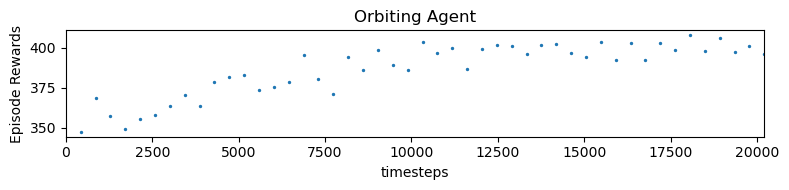

In [7]:
results_plotter.plot_results(
    [log_dir], 1e5, results_plotter.X_TIMESTEPS, "Orbiting Agent"
)